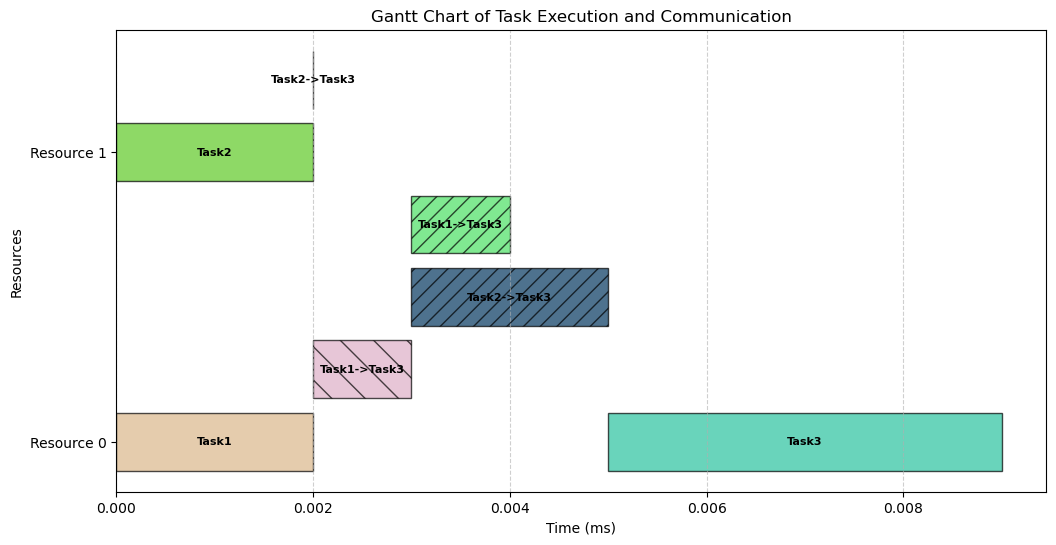

In [1]:
import yaml
import random
import numpy as np
import matplotlib.pyplot as plt

def load_yaml(filename):
    with open(filename, 'r') as file:
        return yaml.safe_load(file)

def scale_time(value, unit):
    scale_factors = {'us': 1, 'ms': 1e3, 's': 1e6, 'min': 6e7}
    return value / scale_factors[unit]

def scale_payload(value, unit):
    scale_factors = {'B': 1, 'KB': 1e3, 'MB': 1e6, 'GB': 1e9}
    return value / scale_factors[unit]

def get_unique_color(existing_colors):
    while True:
        color = (random.random(), random.random(), random.random())
        if color not in existing_colors:
            existing_colors.add(color)
            return color

def plot_gantt(yaml_data, time_unit='us', payload_unit='B', use_numa=True):
    fig, ax = plt.subplots(figsize=(12, 6))
    
    resource_map = {}
    existing_colors = set()
    intervals = []

    comm_name_reads = {}
    for comm, times in yaml_data['comm_name_read_offsets'].items():
        _, task_dest = comm.split('->')
        if task_dest not in comm_name_reads:
            comm_name_reads[task_dest] = 1
        else:
            comm_name_reads[task_dest] += 1

    max_read_key, max_read_value = max(comm_name_reads.items(), key=lambda item: item[1])

    comm_name_writes = {}
    for comm, times in yaml_data['comm_name_write_offsets'].items():
        task_src, _ = comm.split('->')
        if task_src not in comm_name_writes:
            comm_name_writes[task_src] = 1
        else:
            comm_name_writes[task_src] += 1

    max_write_key, max_write_value = max(comm_name_writes.items(), key=lambda item: item[1])

    offset = max_read_value + max_write_value + 1

    # Assigng a tick to every resource.
    for task, locality in yaml_data['name_to_thread_locality'].items():
        resource_id = locality['numa_id'] if use_numa else locality['core_id']
        if resource_id not in resource_map:
            resource_map[resource_id] = len(resource_map)

    for task, times in yaml_data['exec_name_compute_offsets'].items():
        locality = yaml_data['name_to_thread_locality'][task]
        resource_id = locality['numa_id'] if use_numa else locality['core_id']
        y_position = resource_map[resource_id] * offset
        start = scale_time(times['start'], time_unit)
        end = scale_time(times['end'], time_unit)
        color = get_unique_color(existing_colors)
        payload = scale_payload(times['payload'], payload_unit)
        ax.barh(y_position, end - start, left=start, color=color, edgecolor='black', alpha=0.7)
        ax.text((start + end) / 2, y_position, f"{task}", ha='center', va='center', fontsize=8, color='black', weight='bold')

    comm_name_offset = {}
    for comm, times in yaml_data['comm_name_write_offsets'].items():
        task_src, task_dest = comm.split('->')
        resource_id = yaml_data['name_to_thread_locality'][task_src]['numa_id'] if use_numa else yaml_data['name_to_thread_locality'][task_src]['core_id']

        if resource_id not in comm_name_offset:
            comm_name_offset[resource_id] = 1

        y_position = (resource_map[resource_id] * offset) + comm_name_offset[resource_id]
        comm_name_offset[resource_id] += 1

        start = scale_time(times['start'], time_unit)
        end = scale_time(times['end'], time_unit)
        color = get_unique_color(existing_colors)
        payload = scale_payload(times['payload'], payload_unit)
        ax.barh(y_position, end - start, left=start, color=color, edgecolor='black', alpha=0.7, hatch='\\')
        ax.text((start + end) / 2, y_position, f"{comm}", ha='center', va='center', fontsize=8, color='black', weight='bold')

    for comm, times in yaml_data['comm_name_read_offsets'].items():
        _, task_dest = comm.split('->')
        resource_id = yaml_data['name_to_thread_locality'][task_dest]['numa_id'] if use_numa else yaml_data['name_to_thread_locality'][task_dest]['core_id']
        
        if resource_id not in comm_name_offset:
            comm_name_offset[resource_id] = 1

        y_position = (resource_map[resource_id] * offset) + comm_name_offset[resource_id]
        comm_name_offset[resource_id] += 1

        start = scale_time(times['start'], time_unit)
        end = scale_time(times['end'], time_unit)
        color = get_unique_color(existing_colors)
        payload = scale_payload(times['payload'], payload_unit)
        ax.barh(y_position, end - start, left=start, color=color, edgecolor='black', alpha=0.7, hatch='//')
        ax.text((start + end) / 2, y_position, f"{comm}", ha='center', va='center', fontsize=8, color='black', weight='bold')
    
    ax.set_yticks(np.arange(len(resource_map)) * offset)
    ax.set_yticklabels([f"Resource {r}" for r in resource_map.keys()])
    ax.set_xlabel(f"Time ({time_unit})")
    ax.set_ylabel("Resources")
    ax.set_title("Gantt Chart of Task Execution and Communication")
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.show()

# Example usage
data = load_yaml('output_20250206_191948.yml')  # Replace with actual YAML file path
plot_gantt(data, time_unit='ms', payload_unit='MB', use_numa=True)